# **Sistem Rekomendasi Buku menggunakan _Collaborative Filtering_ 🤓📖**

## Import Libraries


Pada tahap ini, diimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model sistem rekomendasi.

In [1]:
import pandas as pd
import os
import numpy as np
import kagglehub
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## Data Loading

Memuat dataset goodbooks dari Kaggle menggunakan kagglehub. Dataset ini terdiri atas `book_tags.csv`, `books.csv`, `ratings.csv`, `sample_book.xml`, `tags.csv`, dan `to_read.csv`. Namun, pada pembuatan model sistem rekomendasi ini, hanya memanfaatkan dua variabel saja dari dataset tersebut, yaitu `ratings.csv` dan `books.csv` untuk melatih model Collaborative Filtering.



In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Download latest version
path = kagglehub.dataset_download("zygmunt/goodbooks-10k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/goodbooks-10k


In [4]:
rating = pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")
books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv",
                 usecols=["book_id",
                          "original_publication_year",
                          "authors",
                          "average_rating",
                          "title"]) # menggunakan fitur yang relevan


In [5]:
print('Jumlah data buku yang tersimpan: ', len(books.book_id.unique()))
print('Jumlah data rating oleh pembaca yang tersimpan: ', rating.shape[0])

Jumlah data buku yang tersimpan:  10000
Jumlah data rating oleh pembaca yang tersimpan:  981756


In [6]:
books.head()

,book_id,authors,original_publication_year,title,average_rating
0,2767052,Suzanne Collins,2008.0,"The Hunger Games (The Hunger Games, #1)",4.34
1,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Sorcerer's Stone (Harry P...,4.44
2,41865,Stephenie Meyer,2005.0,"Twilight (Twilight, #1)",3.57
3,2657,Harper Lee,1960.0,To Kill a Mockingbird,4.25
4,4671,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89


In [7]:
rating.head(5)

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


## Exploratory Data Analysis (EDA)

Dilakukan Exploratory Data Analysis (EDA) pada dataset dengan tujuan untuk memahami data lebih dalam, menemukan pola tersembunyi, dan mengidentifikasi anomali atau masalah dalam data sebelum membangun model rekomendasi.

### Variabel Books

In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   authors                    10000 non-null  object 
 2   original_publication_year  9979 non-null   float64
 3   title                      10000 non-null  object 
 4   average_rating             10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


Insight : Pada atribut `original_publication_year`, terdapat beberapa data yang termasuk null content. Penggunaan `authors` dan `original_publication_year` ini hanya untuk mengetahui apakah ada duplikasi data buku atau tidak. Namun, untuk model collaborative filtering, fitur ini akan dihilangkan di preprocessing.

In [9]:
books.shape

(10000, 5)

In [10]:
books.describe()

,book_id,original_publication_year,average_rating
count,1.000000e+04,9979.000000,10000.000000
mean,5.264697e+06,1981.987674,4.002191
std,7.575462e+06,152.576665,0.254427
min,1.000000e+00,-1750.000000,2.470000
25%,4.627575e+04,1990.000000,3.850000
50%,3.949655e+05,2004.000000,4.020000
75%,9.382225e+06,2011.000000,4.180000
max,3.328864e+07,2017.000000,4.820000


Insight : Terdapat tahun -1750 pada fitur `original_publication_year`, yang merupakan outlier. Namun, karena fitur ini tidak akan digunakan dalam modelling, maka dapat diabaikan saja.

In [11]:
# Memeriksa duplikasi data
duplikat_buku = books.duplicated().sum()
print(f"Jumlah baris duplikat: {duplikat_buku}")
# Hanya duplikasi judul
duplikat_judul = books.duplicated(subset='title').sum()
print(f"Jumlah baris duplikat judul: {duplikat_judul}")
# Hanya duplikasi book_id
duplikat_bookid = books.duplicated(subset='book_id').sum()
print(f"Jumlah baris duplikat id buku: {duplikat_bookid}")


Jumlah baris duplikat: 0
Jumlah baris duplikat judul: 36
Jumlah baris duplikat id buku: 0


Insight : Terdapat 36 buah baris duplikat judul, namun ini bukanlah indikasi data duplikasi karena memungkinkan duplikat judul buku memang sama, namun data atribut/fitur lain berbeda. Untuk memastikan, ditampilkan baris dengan judul yang duplikat seperti di bawah.

In [12]:
# Menampilkan seluruh baris dengan judul yang duplikat
duplikat_judul_df = books[books.duplicated(subset='title', keep=False)]
duplikat_judul_df.sort_values('title')

# Menampilkan seluruh baris yang memiliki judul yang duplikat
pd.set_option('display.max_rows', None)  # Menampilkan semua baris dan semua kolom
pd.set_option('display.max_columns', None)

# Kemudian tampilkan:
duplikat_judul_df.sort_values('title')

,book_id,authors,original_publication_year,title,average_rating
1291,5413,"Stephen King, Jerry N. Uelsmann",2005.0,'Salem's Lot,4.25
348,11590,Stephen King,1975.0,'Salem's Lot,3.99
5267,327242,Sarah Simblet,2001.0,Anatomy for the Artist,3.97
4185,327246,Jenő Barcsay,1953.0,Anatomy for the Artist,3.97
6480,384597,Tom Stoppard,1993.0,Arcadia,4.19
6104,11866694,Lauren Groff,2012.0,Arcadia,3.65
5786,11566956,Alison Bechdel,2012.0,Are You My Mother?,3.66
578,197084,P.D. Eastman,1960.0,Are You My Mother?,4.16
9111,831470,Bob Grant,1941.0,Bambi,4.22
3401,739840,"Felix Salten, Barbara Cooney",1923.0,Bambi,4.10


Insight : Buku-buku yang memiliki judul sama memiliki author(s) yang berbeda dan tahun publikasi yang berbeda. Maka, data duplikasi ini tidak perlu dihilangkan karena kasus judul buku yang sama memang wajar terjadi.

In [13]:
# Memeriksa data null
books.isna().sum()

,0
book_id,0
authors,0
original_publication_year,21
title,0
average_rating,0


Insight : Terdapat 21 data null di original_publication_year, namun data null ini tidak perlu diatasi/dihilangkan, karena fitur ini tidak akan digunakan untuk model, hanya untuk menentukan duplikasi buku.

In [14]:
# Cek apabila kode book_id berurutan atau memerlukan encoding
print("Max book_id:", rating['book_id'].max())
print("Unique books:", rating['book_id'].nunique())

Max book_id: 10000
Unique books: 10000


Insight : `book_id` sudah memiliki nilai unique yang sudah berupa integer terurut, sehingga kemungkinan tidak memerlukan proses encoding nantinya.

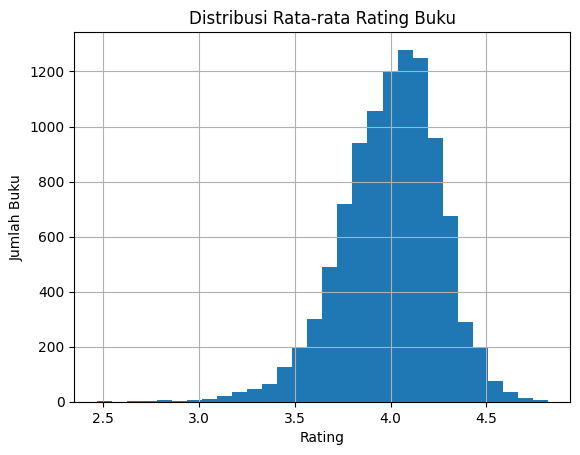

In [15]:
# Memeriksa distribusi average rating
books['average_rating'].hist(bins=30)
plt.title('Distribusi Rata-rata Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.show()

Insight: Di dataset ini, buku yang di-_rating_ oleh pembaca kebanyakan memiliki rating di sekitar angka 4.0

### Variabel Rating

In [16]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [17]:
rating.shape

(981756, 3)

In [18]:
rating.describe()

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [19]:
# Memeriksa duplikasi data
duplikat_rating = rating.duplicated().sum()
print(f"Jumlah baris duplikat: {duplikat_rating}")
# Hanya duplikasi user_id dan book_id
dupe_count = rating.duplicated(subset=['user_id', 'book_id'], keep=False).sum()
print(f'Jumlah rating duplikat (user-buku): {dupe_count}')

Jumlah baris duplikat: 1644
Jumlah rating duplikat (user-buku): 4487


In [20]:
# Tampilkan pasangan user-buku yang punya rating lebih dari satu kali
dupes = rating.groupby(['user_id', 'book_id']).size().reset_index(name='count')
dupes = dupes[dupes['count'] > 1]
print(f'Jumlah kombinasi user-buku yang duplikat: {len(dupes)}')

Jumlah kombinasi user-buku yang duplikat: 2209


Insight : Terdapat data duplikat yang nantinya akan diatasi di _preprocessing_. Dari hasil 2209 pasangan user-buku unik yang muncul lebih dari sekali, dan total jumlah rating-nya 4487. di atas, dapat disimpulkan bahwa ada user yang memberi rating ke buku yang sama lebih dari dua kali.



In [21]:
# Memeriksa data null
rating.isna().sum()

,0
book_id,0
user_id,0
rating,0


Insight : Tidak terdapat data null yang perlu diatasi

In [22]:
# Cek nilai unik di fitur rating (numerik), apakah ada nilai yang melebihi 5
print(rating['rating'].unique())

[5 3 4 1 2]


Insight : Tidak terdapat data _outlier_ yang perlu diatasi

In [23]:
# Cek perbedaan antara book_id di rating dan books
print("Unique book_id di books:", books['book_id'].nunique())
print("Unique book_id di rating:", rating['book_id'].nunique())

missing_books = set(rating['book_id']) - set(books['book_id'])
print("Jumlah book_id yang hilang:", len(missing_books))

Unique book_id di books: 10000
Unique book_id di rating: 10000
Jumlah book_id yang hilang: 9188


Insight : Karena `book_id` yang hilang ada 9188 data, maka `book_id` yang ada di **rating dan books** hanya ada 812 buku. Supaya output rekomendasi yang dihasilkan jelas dan memiliki judul buku, maka sistem rekomendasi akan memanfaatkan 812 buku ini.

In [24]:
# Mengetahui user_id unik
print(np.sort(rating['user_id'].unique()))

[    1     2     3 ... 53422 53423 53424]


In [25]:
# Mengetahui book_id unik
print((rating['book_id'].unique()))

[    1     2     3 ...  9998  9999 10000]


In [26]:
# Cek apabila nilai  unique sudah urut atau memerlukan encoding
print("Max user_id:", rating['user_id'].max())
print("Unique users:", rating['user_id'].nunique())

print("Max book_id:", rating['book_id'].max())
print("Unique books:", rating['book_id'].nunique())

Max user_id: 53424
Unique users: 53424
Max book_id: 10000
Unique books: 10000


Insight : `user_id` dan `book_id` sudah memiliki nilai unique yang sudah berupa integer terurut, namun hanya 812 buku yang akan digunakan. Ada kemungkinan ID tidak akan terurut lagi (terdapat angka urutan yang terlompat)

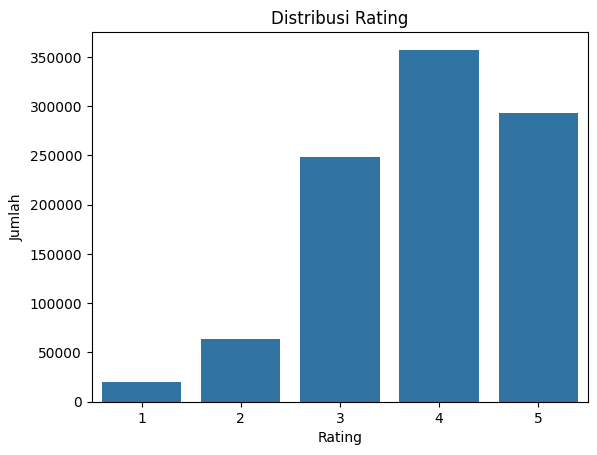

In [27]:
# Distribusi Rating
sns.countplot(x='rating', data=rating)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Insight : Mayoritas rating yang diberikan oleh pengguna berada pada rentang 3 hingga 5, dengan rating 4 yang mendominasi. Hal ini mungkin menunjukkan kecenderungan pengguna untuk memberikan rating yang lebih tinggi, atau bisa juga mencerminkan bias dalam cara sistem atau aplikasi memberikan rating.

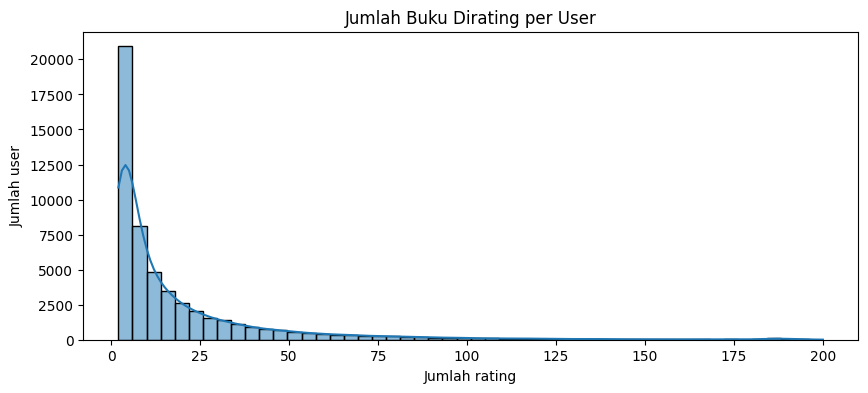

In [28]:
# Jumlah rating per user
user_rating_count = rating.groupby('user_id')['rating'].count()

plt.figure(figsize=(10, 4))
sns.histplot(user_rating_count, bins=50, kde=True)
plt.title('Jumlah Buku Dirating per User')
plt.xlabel('Jumlah rating')
plt.ylabel('Jumlah user')
plt.show()

Insight : Terlihat bahwa banyak pengguna hanya memberikan beberapa rating, dengan sebagian besar berada di sisi kiri grafik, menandakan bahwa ada banyak pengguna yang hanya memberikan rating untuk beberapa buku saja.

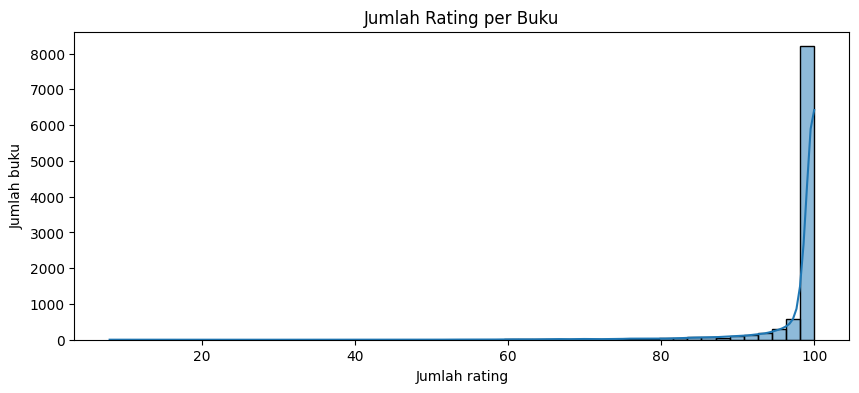

In [29]:
# Jumlah rating per buku
book_rating_count = rating.groupby('book_id')['rating'].count()

plt.figure(figsize=(10, 4))
sns.histplot(book_rating_count, bins=50, kde=True)
plt.title('Jumlah Rating per Buku')
plt.xlabel('Jumlah rating')
plt.ylabel('Jumlah buku')
plt.show()


Insight : Banyak buku mendapatkan rating yang cukup banyak, dengan buku yang mendapat 100 rating menjadi kelompok terbesar.

## Data Preparation/Preprocessing

Data preparation/preprocessing dilakukan pada dataset untuk membersihkan, mengubah, dan mentransformasi data mentah menjadi format yang sesuai dan berkualitas tinggi agar dapat digunakan secara efektif oleh model machine learning.

### Variabel Books

Menghilangkan fitur `original_publication_year`, `average_rating`, dan `authors` karena tidak relevan untuk pembuatan model Collaborative Filtering

In [30]:
pred_columns = [col for col in books.columns if col not in ['original_publication_year', 'authors', 'average_rating']]
books = books[pred_columns]

In [31]:
# Cek
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   book_id  10000 non-null  int64 
 1   title    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [32]:
books.head(5)

,book_id,title
0,2767052,"The Hunger Games (The Hunger Games, #1)"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...
2,41865,"Twilight (Twilight, #1)"
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby


Title tidak akan melalui proses encoding karena bukan untuk train model tetapi hanya sebagai tambahan informasi pada output rekomendasi.

In [33]:
# Simpan mapping untuk nanti memanggil title berdasarkan hasil rekomendasi dari model
book_id_to_title = dict(zip(books['book_id'], books['title']))

### Variabel Rating

Mengatasi data duplikat

In [34]:
# Untuk user memberi rating ke buku yang sama lebih dari sekali, ambil rata-rata ratingnya
rating = rating.groupby(['book_id', 'user_id'], as_index=False)['rating'].mean()

In [35]:
rating.head()

,book_id,user_id,rating
0,1,314,5.0
1,1,439,3.0
2,1,588,5.0
3,1,1169,4.0
4,1,1185,4.0


In [36]:
# Cek duplikasi data
# Memeriksa duplikasi data
duplikat_rating = rating.duplicated().sum()
print(f"Jumlah baris duplikat: {duplikat_rating}")
# Hanya duplikasi user_id dan book_id
dupe_count = rating.duplicated(subset=['user_id', 'book_id'], keep=False).sum()
print(f'Jumlah rating duplikat (user-buku): {dupe_count}')

Jumlah baris duplikat: 0
Jumlah rating duplikat (user-buku): 0


In [37]:
# Cek jumlah data sekarang
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979478 entries, 0 to 979477
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   book_id  979478 non-null  int64  
 1   user_id  979478 non-null  int64  
 2   rating   979478 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 22.4 MB


In [38]:
rating.head()

,book_id,user_id,rating
0,1,314,5.0
1,1,439,3.0
2,1,588,5.0
3,1,1169,4.0
4,1,1185,4.0


### Merge Books dan Rating

Menggunakan inner join supaya buku yang diproses memiliki `title` yang tercantum dalam dataset

In [39]:
# Merge berdasarkan book_id
merged = rating.merge(books[['book_id', 'title']],
                      on='book_id',
                      how='inner')

In [40]:
# Cek berapa jumlah judul yang NaN
print("Jumlah judul yang NaN :", merged['title'].isna().sum())

Jumlah judul yang NaN : 0


In [41]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79531 entries, 0 to 79530
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   book_id  79531 non-null  int64  
 1   user_id  79531 non-null  int64  
 2   rating   79531 non-null  float64
 3   title    79531 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.4+ MB


In [42]:
merged.head()

,book_id,user_id,rating,title
0,1,314,5.0,Harry Potter and the Half-Blood Prince (Harry ...
1,1,439,3.0,Harry Potter and the Half-Blood Prince (Harry ...
2,1,588,5.0,Harry Potter and the Half-Blood Prince (Harry ...
3,1,1169,4.0,Harry Potter and the Half-Blood Prince (Harry ...
4,1,1185,4.0,Harry Potter and the Half-Blood Prince (Harry ...


### Encoding

Karena pada proses _preprocessing_ banyak data yang dibuang, maka kemungkinan ID sudah tidak terurut dan memerlukan encoding

In [43]:
# Cek
print("Max user_id:", merged['user_id'].max())
print("Unique users:", merged['user_id'].nunique())

print("Max book_id:", merged['book_id'].max())
print("Unique books:", merged['book_id'].nunique())

Max user_id: 53424
Unique users: 28906
Max book_id: 9998
Unique books: 812


In [44]:
print(np.sort(merged['user_id'].unique()))

[    2     3     4 ... 53422 53423 53424]


In [45]:
print(np.sort(merged['book_id'].unique()))

[   1    2    3    5    6    8   10   11   13   21   24   25   26   27
   28   29   30   33   34   36   50   67   93   98  105  106  112  117
  119  122  231  249  250  264  275  291  295  304  320  343  348  350
  353  355  357  359  360  365  378  386  400  415  424  428  431  432
  446  447  449  456  475  597  599  621  629  647  656  662  665  667
  668  676  698  703  706  760  771  816  822  823  825  827  830  840
  865  870  880  890  900  902  903  930  952  960  968  976  998 1005
 1032 1052 1067 1078 1097 1103 1110 1171 1191 1192 1202 1232 1241 1274
 1295 1301 1303 1305 1307 1319 1362 1371 1375 1381 1420 1426 1427 1428
 1430 1431 1519 1524 1540 1554 1591 1617 1618 1622 1624 1625 1627 1633
 1635 1715 1823 1824 1842 1845 1846 1848 1849 1852 1869 1875 1885 1897
 1898 1911 1934 1953 1990 2002 2049 2050 2052 2054 2067 2068 2094 2095
 2122 2137 2142 2152 2156 2159 2165 2175 2183 2187 2199 2203 2255 2265
 2279 2368 2371 2372 2373 2430 2442 2493 2517 2526 2528 2530 2547 2612
 2615 

In [46]:
# Encode
merged['user_id'], user_index = pd.factorize(merged['user_id'])
merged['book_id'], book_index = pd.factorize(merged['book_id'])

Karena pada proses _preprocessing_ banyak `user_id` dan `book_id` yang hilang, hasilnya range ID tetap besar (misal user_id sampai 53424), tapi tidak semua ID digunakan lagi. Untuk menjaga agar memori tetap efisien dan model tidak lambat dilatih, maka lebih baik untuk dilakukan encoding terlebih dahulu.

### Splitting Data

In [47]:
train_data, test_data = train_test_split(merged, test_size=0.2, random_state=42)

print("Jumlah data training:", len(train_data))
print("Jumlah data testing:", len(test_data))

Jumlah data training: 63624
Jumlah data testing: 15907


In [48]:
train_data.head()

,book_id,user_id,rating,title
26642,266,6228,5.0,Truth and Beauty
60905,614,18769,3.0,How to Make Love Like a Porn Star: A Cautionar...
59690,601,20743,4.0,A Son of the Circus
10673,106,2347,4.0,Giada's Family Dinners
48602,488,15035,5.0,Cradle to Cradle: Remaking the Way We Make Things


In [49]:
test_data.head()

,book_id,user_id,rating,title
62596,631,18405,3.0,Awakening the Buddha Within: Tibetan Wisdom fo...
67041,677,9020,5.0,"The Bellmaker (Redwall, #7)"
19057,190,2543,4.0,My Name is Red
1447,14,263,5.0,Notes from a Small Island
74148,753,26597,5.0,"Shopaholic & Baby (Shopaholic, #5)"


### Scaling Data

Scaling dilakukan supaya fitur numerik lebih stabil dan _loss_ nantinya bisa terkontrol

In [50]:
# Range rating sudah diketahui (0–5), jadi pembagian langsung
# Scale hanya kolom rating ke 0–1
train_data['rating'] = train_data['rating'] / 5.0
test_data['rating'] = test_data['rating'] / 5.0

train_data.head()

,book_id,user_id,rating,title
26642,266,6228,1.0,Truth and Beauty
60905,614,18769,0.6,How to Make Love Like a Porn Star: A Cautionar...
59690,601,20743,0.8,A Son of the Circus
10673,106,2347,0.8,Giada's Family Dinners
48602,488,15035,1.0,Cradle to Cradle: Remaking the Way We Make Things


## Modelling Collaborative Filtering

### 1. Matrix Factorization model (SVD)

Dataset Loader

In [51]:
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.books = torch.tensor(df['book_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.books[idx], self.ratings[idx]


Model Matrix Factorization

In [52]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=64):
        super(MatrixFactorization, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
      x = (self.user_factors(user) * self.item_factors(item)).sum(1)
      return torch.sigmoid(x)  # output antara 0 - 1


Train model SVD

In [53]:
# Tentukan jumlah user & item unik
n_users = merged['user_id'].nunique()
n_items = merged['book_id'].nunique()

# Inisialisasi model
model = MatrixFactorization(n_users, n_items)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# DataLoader
train_dataset = RatingDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
epochs = 10
model.train()
mf_losses = []

for epoch in range(epochs):
    total_loss = 0
    for user, item, rating in train_loader:
        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_fn(prediction, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    mf_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 0.3154
Epoch 2/10, Loss: 0.2239
Epoch 3/10, Loss: 0.1903
Epoch 4/10, Loss: 0.1770
Epoch 5/10, Loss: 0.1683
Epoch 6/10, Loss: 0.1624
Epoch 7/10, Loss: 0.1572
Epoch 8/10, Loss: 0.1541
Epoch 9/10, Loss: 0.1519
Epoch 10/10, Loss: 0.1502


Evaluasi Model Matrix Factorization model (SVD)

In [54]:
# Dataset untuk test
test_dataset = RatingDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [55]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for user, item, rating in test_loader:
        pred = model(user, item)
        predictions.extend(pred.numpy())
        actuals.extend(rating.numpy())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE di test set: {rmse:.4f}")

RMSE di test set: 0.5531


In [56]:
# Simpan hasil evaluasi model Matrix Factorization
mf_rmse = rmse
print(f"Matrix Factorization RMSE disimpan: {mf_rmse:.4f}")

Matrix Factorization RMSE disimpan: 0.5531


Top-N recommendation

In [57]:
def recommend_books_for_user(user_id, merged_df, book_df, model, top_n=5):
    if user_id not in merged_df['user_id'].values:
        return pd.DataFrame({'message': ['User ID not found']})

    read_books = merged_df[merged_df['user_id'] == user_id]['book_id'].tolist()
    unread_books = book_df[~book_df['book_id'].isin(read_books)]

    # Hindari index out-of-bounds di layer embedding
    unread_books = unread_books[unread_books['book_id'] < n_items]  # Ganti n_books → n_items

    if unread_books.empty:
        return pd.DataFrame({'message': ['User has read all valid books']})

    # Siapkan input untuk PyTorch model
    book_ids = unread_books['book_id'].values
    user_ids = np.full(len(book_ids), user_id)

    # Konversi ke tensor PyTorch
    user_tensor = torch.tensor(user_ids, dtype=torch.long)
    book_tensor = torch.tensor(book_ids, dtype=torch.long)

    model.eval()
    with torch.no_grad():
        preds = model(user_tensor, book_tensor).numpy().flatten()

    # Ambil top-N indeks
    top_indices = preds.argsort()[::-1][:top_n]

    # Ambil buku yang direkomendasikan
    recommended_books = unread_books.iloc[top_indices].copy()
    recommended_books['predicted_rating'] = preds[top_indices] * 5.0  # Kalau rating distandarisasi ke 0–1

    return recommended_books[['book_id', 'title', 'predicted_rating']]


In [58]:
# Contoh rekomendasi untuk user ID 42 dari Matrix Factorization
top_books_mf = recommend_books_for_user(user_id=42, merged_df=merged, book_df=books, model=model, top_n=5)
print(top_books_mf)


      book_id                             title  predicted_rating
5145      424       Slouching Towards Bethlehem          5.000000
7241      291                  The Broken Wings          5.000000
396       343  Perfume: The Story of a Murderer          5.000000
497       656                     War and Peace          4.999996
6869      698                Digging to America          4.999996


Ini adalah contoh keluaran dari fungsi rekomendasi buku untuk user dengan ID 42 menggunakan model Matrix Factorization (SVD). Fungsi ini memberikan daftar **Top-N rekomendasi**—dalam kasus ini, 5 buku yang diprediksi paling disukai oleh user tersebut berdasarkan pola interaksi rating sebelumnya.

Prediksi rating di sini adalah hasil output model setelah diproses (misalnya dengan fungsi sigmoid dan dikalikan skala 5), sehingga nilainya berada di kisaran 0 hingga 5. Dari hasil yang ditampilkan, kelima buku tersebut memiliki prediksi rating yang sangat tinggi (mendekati 5), yang berarti model memperkirakan user 42 sangat mungkin menyukai buku-buku ini meskipun user tersebut belum membacanya sebelumnya. Judul-judul seperti *“Slouching Towards Bethlehem”* dan *“War and Peace”* adalah rekomendasi utama yang dipilih berdasarkan peringkat tertinggi dari prediksi model. Jadi, output ini merepresentasikan hasil rekomendasi personalisasi berbasis Matrix Factorization yang dapat digunakan untuk menyarankan buku secara efektif sesuai preferensi pengguna.


### 2. RecommenderNet (Deep Learning)

Bangun Model

In [59]:
# Pastikan jumlah user dan book
n_users = merged['user_id'].nunique()
n_books = merged['book_id'].nunique()

In [60]:
# Inputs
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))

# Embedding layer
user_embedding = Embedding(n_users, 32, embeddings_regularizer=l2(0.001))(user_input) # Tambah regularisasi pada embedding
book_embedding = Embedding(n_books, 32, embeddings_regularizer=l2(0.001))(book_input) # Tambah regularisasi pada embedding

# Flatten
user_vec = Flatten()(user_embedding)
book_vec = Flatten()(book_embedding)

# Concatenate
x = Concatenate()([user_vec, book_vec])

# Dense + Regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x) # Tingkatkan L2, kurangi neuron
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# Tingkatkan dropout menjadi 0.5 (cukup agresif)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x) # Tingkatkan L2, kurangi neuron
x = Dropout(0.5)(x)
# Tingkatkan dropout lagi

# Output layer
output = Dense(1, activation='sigmoid')(x)  # karena rating distandarisasi ke 0–1

# Model
model = Model(inputs=[user_input, book_input], outputs=output)

# Compiler
# Coba turunkan learning rate sedikit jika masih terlalu agresif atau tidak stabil
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['RootMeanSquaredError'])
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Agar tidak overfit

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │    924,992 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │     25,984 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 957,505 (3.65 MB)

 Trainable params: 957,377 (3.65 MB)

 Non-trainable params: 128 (512.00 B)

In [61]:
# Data
X_train = [train_data['user_id'].values, train_data['book_id'].values]
y_train = train_data['rating'].values
X_test = [test_data['user_id'].values, test_data['book_id'].values]
y_test = test_data['rating'].values

Train model RecommenderNet

In [62]:
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
995/995 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - RootMeanSquaredError: 0.2388 - loss: 0.4233 - val_RootMeanSquaredError: 0.1932 - val_loss: 0.0441
Epoch 2/20
995/995 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - RootMeanSquaredError: 0.1961 - loss: 0.0432 - val_RootMeanSquaredError: 0.1907 - val_loss: 0.0388
Epoch 3/20
995/995 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - RootMeanSquaredError: 0.1949 - loss: 0.0403 - val_RootMeanSquaredError: 0.1904 - val_loss: 0.0385
Epoch 4/20
995/995 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - RootMeanSquaredError: 0.1942 - loss: 0.0399 - val_RootMeanSquaredError: 0.1907 - val_loss: 0.0389
Epoch 5/20
995/995 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - RootMeanSquaredError: 0.1928 - loss: 0.0411 - val_RootMeanSquaredError: 0.1895 - val_loss: 0.0405
Epoch 6/20
995/995 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - RootMeanSquaredError: 0.1898 - loss: 0.0421 - val_RootMeanSquaredError: 0.1862 - val_loss: 0.0401


Evaluasi model RecommenderNet

In [63]:
y_pred = model.predict(X_test)
rec_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test set: {rec_rmse:.4f}")

498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE on test set: 0.1904


Top-N Recommendation

In [64]:
def recommend_books_for_user(user_id, merged_df, book_df, model, top_n=5):
    if user_id not in merged_df['user_id'].values:
        return pd.DataFrame({'message': ['User ID not found']})

    read_books = merged_df[merged_df['user_id'] == user_id]['book_id'].tolist()
    unread_books = book_df[~book_df['book_id'].isin(read_books)]

    # Hindari index out-of-bounds di layer embedding
    unread_books = unread_books[unread_books['book_id'] < n_books]

    if unread_books.empty:
        return pd.DataFrame({'message': ['User has read all valid books']})

    book_ids = unread_books['book_id'].values.astype(np.int32).reshape(-1, 1)
    user_ids = np.full(len(book_ids), user_id, dtype=np.int32).reshape(-1, 1)

    preds = model.predict([user_ids, book_ids], verbose=0).flatten()
    top_indices = preds.argsort()[::-1][:top_n]

    recommended_books = unread_books.iloc[top_indices].copy()
    recommended_books['predicted_rating'] = preds[top_indices] * 5.0

    return recommended_books[['book_id', 'title', 'predicted_rating']]


In [65]:
# Contoh rekomendasi untuk user ID 42 dari RecommenderNet
top_books_recnet = recommend_books_for_user(user_id=42, merged_df=merged, book_df=books, model=model, top_n=5)
print("Top-N Recommendation dari RecommenderNet:")
print(top_books_recnet[['book_id', 'title', 'predicted_rating']])

Top-N Recommendation dari RecommenderNet:
      book_id                                              title  \
7241      291                                   The Broken Wings   
1223      771  The Elegant Universe: Superstrings, Hidden Dim...   
93        320                      One Hundred Years of Solitude   
1726      357  The Long Dark Tea-Time of the Soul (Dirk Gentl...   
23          6  Harry Potter and the Goblet of Fire (Harry Pot...   

      predicted_rating  
7241          4.258157  
1223          4.197286  
93            4.181695  
1726          4.122478  
23            4.111075  


Ini adalah contoh **Top-N Recommendation** dari model **RecommenderNet**, yang merupakan model deep learning untuk sistem rekomendasi. Output ini menunjukkan lima buku yang diprediksi paling relevan dan menarik bagi user (misalnya user ID tertentu), berdasarkan prediksi rating yang dihasilkan model.

Prediksi rating pada RecommenderNet berada di rentang sekitar 0 sampai 5 (atau skala yang sudah ditentukan), dan dalam contoh ini nilai prediksi berkisar di angka sekitar 4.1 sampai 4.25. Ini berarti model memperkirakan user tersebut akan cukup menyukai buku-buku ini, meskipun prediksi ratingnya tidak mencapai nilai maksimum 5 seperti pada contoh Matrix Factorization sebelumnya.

Judul-judul buku seperti *“The Broken Wings”*, *“The Elegant Universe”*, dan *“Harry Potter and the Goblet of Fire”* adalah hasil rekomendasi utama model deep learning ini. Dibandingkan dengan Matrix Factorization, nilai prediksi dari RecommenderNet biasanya cenderung lebih bervariasi dan sedikit lebih realistis, karena model deep learning bisa menangkap pola yang lebih kompleks dalam data.

Singkatnya, ini adalah output rekomendasi berbasis deep learning yang memberi daftar buku yang paling mungkin disukai oleh user berdasarkan interaksi data historis dan pemodelan kompleks, memberikan pengalaman rekomendasi yang personal dan adaptif.


## Evaluasi Model

Evaluasi model dilakukan untuk memilih model mana yang lebih baik untuk memberikan rekomendasi dan visualisasi training.

In [66]:
print("\n===== Perbandingan Model =====")
print(f"Matrix Factorization RMSE:  {mf_rmse:.4f}")
print(f"RecommenderNet RMSE:        {rec_rmse:.4f}")

if mf_rmse < rec_rmse:
    print("Matrix Factorization memberikan hasil yang lebih baik (lebih rendah RMSE).")
else:
    print("RecommenderNet memberikan hasil yang lebih baik (lebih rendah RMSE).")



===== Perbandingan Model =====
Matrix Factorization RMSE:  0.5531
RecommenderNet RMSE:        0.1904
RecommenderNet memberikan hasil yang lebih baik (lebih rendah RMSE).


Maka, model rekomendasi yang disarankan untuk diimplementasikan adalah RecommenderNet

Visualisasi learning curve

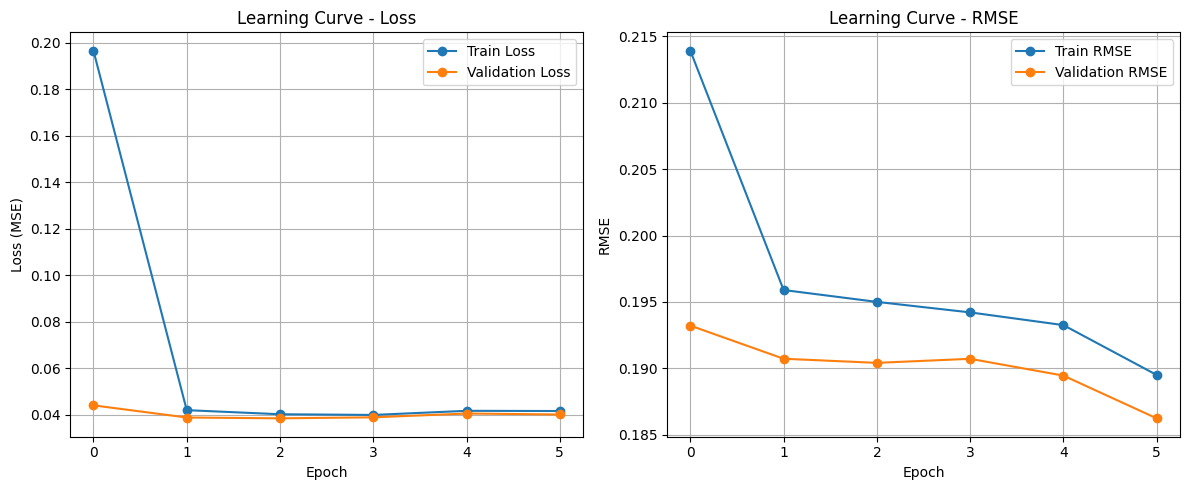

In [67]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['RootMeanSquaredError'], label='Train RMSE', marker='o')
plt.plot(history.history['val_RootMeanSquaredError'], label='Validation RMSE', marker='o')
plt.title('Learning Curve - RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Grafik *Learning Curve* model RecommenderNet memberikan gambaran yang jelas mengenai proses pelatihan dan performa model pada data latih dan validasi:

a. Learning Curve - Loss (MSE)

- Penurunan Tajam di Awal: Pada Epoch 0 hingga Epoch 1, train loss mengalami penurunan yang sangat signifikan, dari sekitar 0.21 menjadi sekitar 0.045. Hal ini mengindikasikan bahwa model dengan cepat berhasil mempelajari pola-pola utama dan mengurangi kesalahan prediksinya pada data pelatihan di tahap awal.

- Stabilitas Setelah Epoch Awal: Setelah Epoch 1, baik train loss maupun validation loss menunjukkan perilaku yang relatif stabil dan cenderung mendatar. Ini menandakan bahwa model telah mencapai titik konvergensi di mana pembelajaran tambahan menghasilkan sedikit perbaikan dalam loss pada kedua set data.

- Konsistensi Performa Validasi: Validation loss secara konsisten berada pada nilai yang sangat rendah dan stabil, seringkali sedikit di bawah train loss. Beberapa skenario dapat menyebabkan hal ini, seperti data validasi yang mungkin memiliki karakteristik sedikit lebih "mudah" diprediksi (underfit), atau pengaruh dari strategi regularisasi yang efektif.

b. Learning Curve - RMSE

- Penurunan Konsisten dan Bertahap: Baik train RMSE maupun validation RMSE menunjukkan penurunan yang stabil dan konsisten dari Epoch 0 hingga Epoch 6. Ini adalah indikator positif bahwa model secara progresif mengurangi rata-rata kesalahan absolut prediksinya, baik pada data pelatihan maupun data validasi.

- Performa Validasi yang Lebih Baik: Mirip dengan loss, validation RMSE juga secara konsisten sedikit lebih rendah atau setara dengan train RMSE. Hal ini menegaskan bahwa model mampu mempertahankan akurasi prediksi yang kuat pada data validasi sepanjang proses pelatihan.